<a href="https://colab.research.google.com/github/s1m0n32001/PercolationML/blob/main/DomanyKinzelUnsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning of Directed Percolation

## Physics of Complex Systems, Final Project

### Student: Simone Toso (2095484)

The goal of this project is to implement the method described in the paper *Supervised and unsupervised learning of directed percolation* (Shen et. al).

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install graphviz

In [4]:
!pip install torchview
!pip3 install Cython

In [5]:
import torch
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader, random_split
from scipy.stats import linregress as linear_fit
from scipy.optimize import curve_fit

# For network visualization
import graphviz
from torchview import draw_graph

torch.manual_seed(1235)
np.random.seed(1235)

# Use GPU if runtime allows it, otherwise use CPU
device = None
if torch.cuda.is_available():
  device = torch.device("cuda") #to use gpu
else:
  device = torch.device("cpu")

In [6]:
print("GPUs available:", torch.cuda.is_available())

GPUs available: True


Domany Kinzel model

In [7]:
"""
Function to simulate bond DP in (1+1) dimension.
 L: lattice size
 T: timesteps to simulate
 p: bond probability
 z_minus: tensor of shape (T,L) with values in [0,1], bond probability between site i and i-1
 z_plus: same thing, for site i and i+1
 full: if True, initiate all sites as active. If False, only site L//2 is initiated as active
"""

def simulate_DK(L: int, T:int, p: float, q : float,
                device : torch.device = torch.device("cpu"),
                full: bool = False) -> torch.Tensor:
  config = torch.zeros((T, L)).to(device)
  z_minus, z_plus, zq = torch.rand((T,L)).to(device), torch.rand((T,L)).to(device), torch.rand((T,L)).to(device)

  # Initialize configuration
  if full:
    config[0, :] = 1
  else:
    config[0, L//2] = 1

  # Compute active and inactive sites
  for t in range(1, T):
    mask_left = torch.roll(config[t-1, :], shifts = -1)
    mask_left[-1] = 0                                   # border condition
    mask_right = torch.roll(config[t-1, :], shifts = 1)
    mask_right[0] = 0                                   # border condition
    # either only one with p, or both with q
    config[t, :] = torch.bitwise_or(torch.bitwise_or(torch.bitwise_and(torch.bitwise_and(mask_left > 0, mask_right == 0), z_minus[t, :] < p),
                                    torch.bitwise_and(torch.bitwise_and(mask_right > 0, mask_left == 0), z_plus[t, :] < p)),
                                    torch.bitwise_and(torch.bitwise_and(mask_right > 0, mask_left > 0), zq[t, :] < q))
  return config


In [8]:
# Generate dataset for training
L, T = 60, 80

ps = np.linspace(0.3, 0.9, 12)
qs = np.linspace(0.05, 0.99, 8)

n_samples = 100
n_samples * len(ps) * len(qs) * L * T

46080000

### Generate data (run only once)

In [ ]:
## Generate 500 configurations for each (p,q) value
data = np.zeros((n_samples * len(ps) * len(qs), T, L))

for i,p in enumerate(ps):
  print(str(i) + "out of " + str(len(ps)) + "\n")
  for j,q in enumerate(qs):
    for k in range(n_samples):
      index = i*len(qs)*n_samples + j*n_samples + k
      data[index, :, :] = simulate_DK(L, T, p, q, device, True)

In [ ]:
file_name = "/content/drive/MyDrive/dataset_autoencoder_DK_new"
torch.save(data, file_name)

### Train autoencoder for DK model

In [9]:
# Load data
data = torch.load("/content/drive/MyDrive/dataset_autoencoder_DK_new",
                  map_location=torch.device(device))

In [10]:
data.shape

(9600, 80, 60)

In [11]:
data = torch.unsqueeze(torch.tensor(data), 1).to(torch.float32)

# Split into training and test (80%, 20%)
#index_train = [i*n_samples + j*len(qs) + k for i in range(len(ps)) for j in range(80*n_samples // 100)]
#index_test = [i*n_samples + 80*n_samples // 100 + j for i in range(len(ps)) for j in range(n_samples * 20 // 100)]
#data_train, data_test = data[index_train, :], data[index_test, :]

data_train = data

# Create datasets and dataloaders
batch_size = 32
training_set = TensorDataset(data_train)
train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)

In [12]:
data.shape

torch.Size([9600, 1, 80, 60])

In [31]:
""" Autoencoder architecture:
 - Encoder: two convolutional layers with two MaxPooling layers
 - Hidden: one hidden neuron
 - Decoder: two convolutional layers, two upsampling layers
"""

class AutoencoderDK(nn.Module):
  def __init__(self, L, T):
    super(AutoencoderDK, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 8, kernel_size = 3, padding = 'same', padding_mode = 'zeros'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.Conv2d(8, 16, kernel_size = 3, padding = 'same', padding_mode = 'zeros'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )

    self.projection = nn.Linear(L*T, 1)
    self.projection2 = nn.Linear(1, L*T)

    self.decoder = nn.Sequential(nn.Conv2d(16, 8, kernel_size = 3, padding = 'same', padding_mode = 'zeros'),
                                 nn.ReLU(),
                                 nn.Upsample(scale_factor = 2),
                                 nn.Conv2d(8, 1, kernel_size = 3, padding = 'same', padding_mode = 'zeros'),
                                 nn.ReLU(),
                                 nn.Upsample(scale_factor = 2))

  def forward(self, data):
    encoded = self.encoder(data)
    encoded = torch.flatten(encoded, start_dim = 1, end_dim = -1)

    hidden = torch.sigmoid(self.projection(encoded))

    decoded = torch.reshape(self.projection2(hidden), (-1, 16, T//4, L//4))
    decoded = self.decoder(decoded)

    return decoded, hidden

  def generate_sample(self, h):
    hidden = h
    decoded = torch.reshape(self.projection2(hidden), (-1, 16, T//4, L//4))
    decoded = self.decoder(decoded)

    return decoded

In [32]:
inputs[0]

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 0., 1., 1.],
          [1., 1., 0.,  ..., 1., 1., 0.],
          ...,
          [1., 1., 0.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 1., 0., 0.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 0., 0.,  ..., 0., 0., 1.],
          [0., 1., 0.,  ..., 0., 1., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 0., 1.,  ..., 0., 0., 1.],
          [0., 0., 1.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 0., 0.,  ..., 1., 0., 1.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [33]:
# Train the autoencoder!
autoencoderDK = AutoencoderDK(L, T).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoderDK.parameters(), lr=0.001, weight_decay=0.01)

n_epochs = 4

print("Train losses: \n")
for epoch in range(n_epochs):
  ## Training loss
  autoencoderDK.train()
  train_loss = 0.0
  for inputs in train_loader:
    optimizer.zero_grad()
    outputs, _ = autoencoderDK(inputs[0].to(torch.float32).to(device))
    loss = criterion(outputs, inputs[0].to(device))
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * inputs[0].size(0)
  train_loss /= len(train_loader.dataset)
  print(train_loss)


Train losses: 

0.13752861139674982
0.10913115181028843
0.10942378219217062
0.10674627040823301


In [34]:
# For each value of p, take the possible qs, find average sigmoid and fit with tanh
array = np.zeros((len(qs), len(ps)))

for i, p in enumerate(ps):
  tensor = data[i*len(qs)*n_samples: i*len(qs)*n_samples + len(qs) * n_samples, :, :, :]
  _, hiddens = autoencoderDK(tensor.to(device))
  average_hiddens = np.zeros(len(qs))
  # hiddens has length len(qs) * N
  hiddens = hiddens[:, 0].cpu().detach().numpy()
  for j,q in enumerate(qs):
    average_hiddens[j] = np.mean(hiddens[j*n_samples: (j+1)*n_samples])
  array[:, i] = average_hiddens

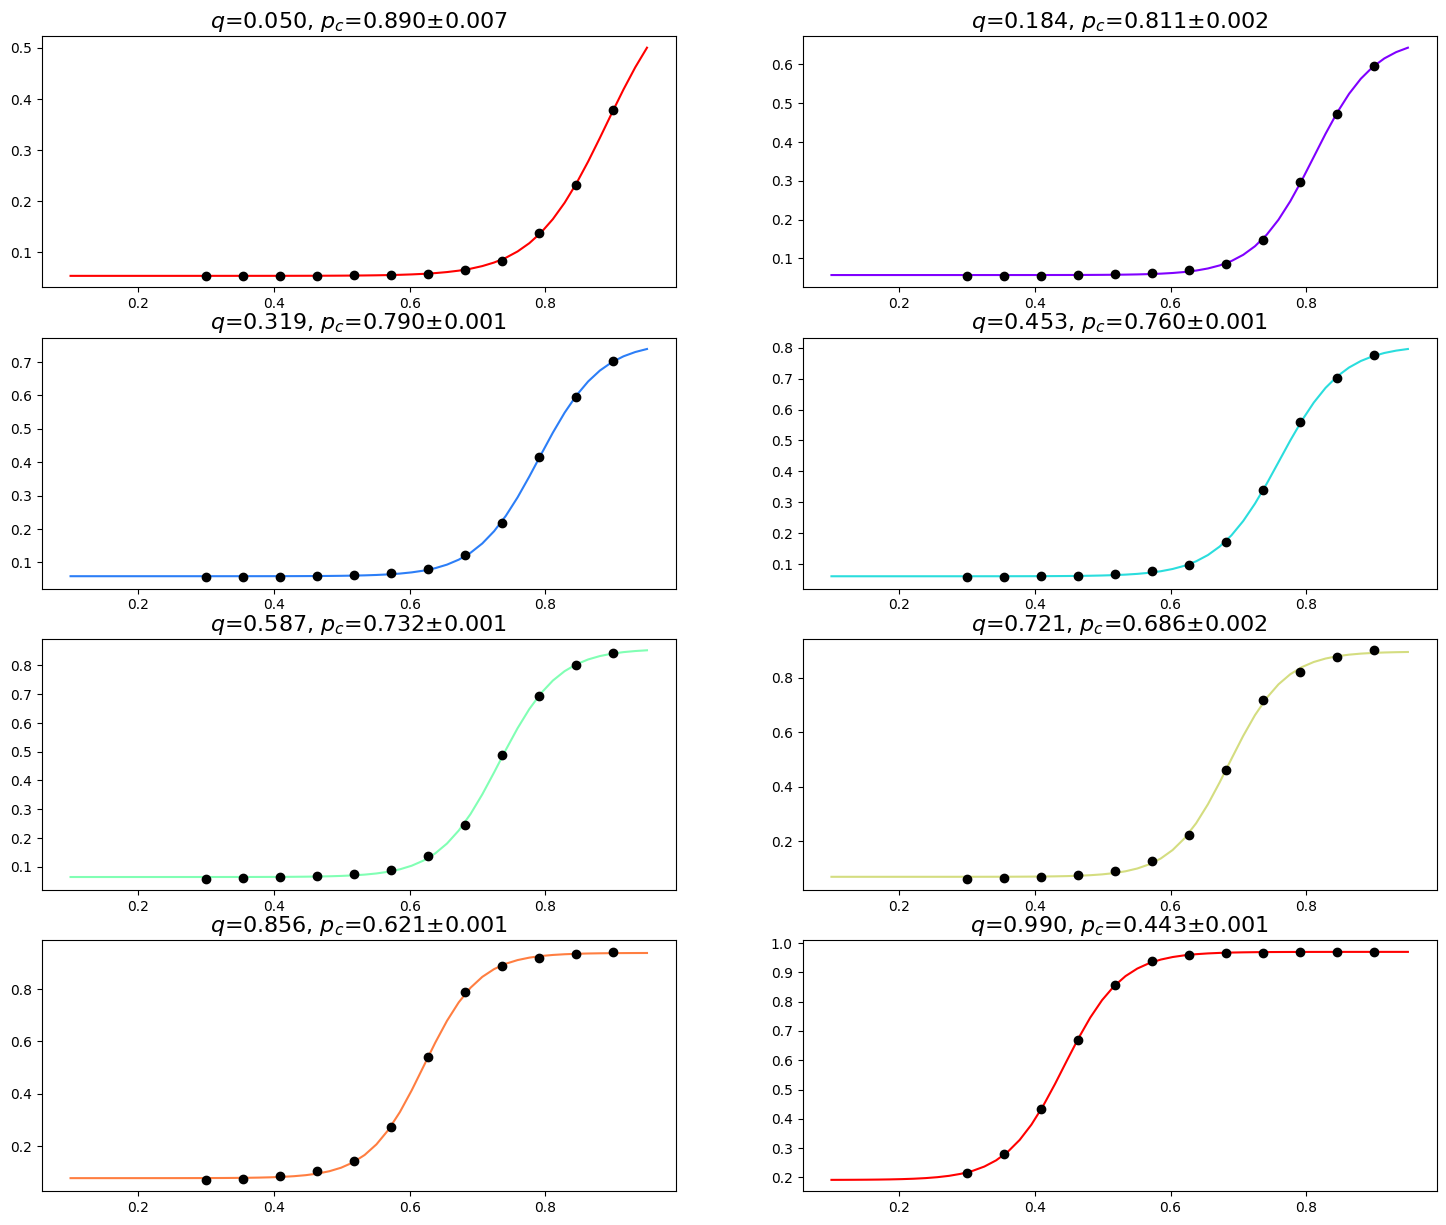

In [35]:
import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, 1, len(qs) - 1))

def tanh(x, a, b, pc, c):
  return c + a*np.tanh(b*(x-pc))

fig, ax = plt.subplots(nrows = (len(qs) - 1) // 2 + 1, ncols = 2, figsize = (18, 15))
ps_critical = []
for i in range(len(qs)):
  params, covs = curve_fit(tanh, ps, array[i, :])
  ax[(i) // 2, (i)%2].set_title(r"$q$" +f'={qs[i]:0.3f}' + ", " + r"$p_c$" + f'={params[2]:0.3f}' + r'$\pm$' + f'{np.sqrt(covs[2,2]):0.3f}', fontsize = 16)
  ax[(i) // 2, (i)%2].plot(np.linspace(0.1, 0.95), tanh(np.linspace(0.1,0.95), *params), c = colors[i-1])
  ax[(i) // 2, (i)%2].plot(ps, array[i, :], "o", c = 'black')
  ps_critical.append(params[2])

Adesso ricreiamo il grafico dei punti critici $(p, q)$ per il modello di Domany-Kinzel.

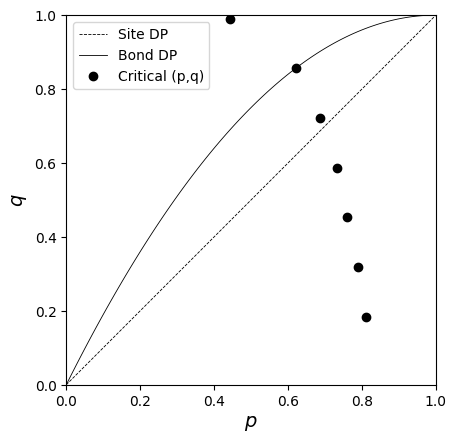

In [36]:
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), c = 'black', linestyle = '--', linewidth = .6, label = 'Site DP')
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100) * (2 - np.linspace(0, 1, 100)), c = 'black', linestyle = '-', linewidth = .6, label = 'Bond DP')
plt.plot(ps_critical[1:], qs[1:] , "o", c = "black", label = "Critical (p,q)")

plt.figsize = (11,11)
plt.xlabel(r"$p$", fontsize = 14)
plt.ylabel(r"$q$", fontsize = 14)
plt.axis([0, 1, 0, 1])
plt.gca().set_aspect(aspect='equal', adjustable='box')
plt.legend(loc = 'upper left')


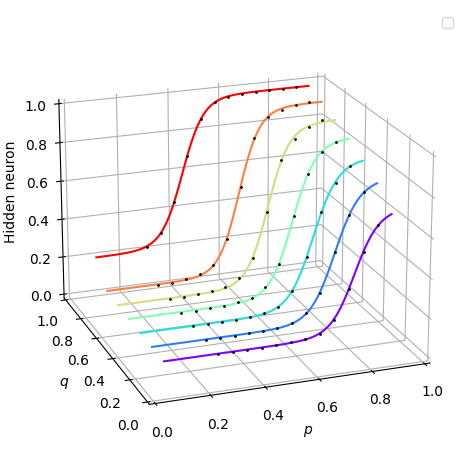

In [37]:
from mpl_toolkits.mplot3d import Axes3D
ax = plt.figure().add_subplot(projection='3d', facecolor='white')

# Plot a sin curve using the x and y axes.
#for p in ps:
#  for q in qs:
#    ax.scatter(p, q, zs=0, zdir='z', marker = 'o', c = "gray", s = .3)

for i, p in enumerate(ps):
  for j, q in enumerate(qs[1:]):
    ax.scatter(p, q, zs =array[j+1, i], zdir='z', marker = 'o', c = "black", s = 1)
colors = cm.rainbow(np.linspace(0, 1, len(qs) - 1))

def tanh(x, a, b, pc, c):
  return c + a*np.tanh(b*(x-pc))

ps_critical = []
for i in range(1, len(qs)):
  params, covs = curve_fit(tanh, ps, array[i, :])
  ax.plot(np.linspace(0.1, 0.95, 100), np.array([qs[i]]*100), tanh(np.linspace(0.1,0.95, 100), *params), c = colors[i-1])
  ps_critical.append(params[2])


# Make legend, set axes limits and labels
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$q$')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Hidden neuron', rotation=90)

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=20., azim=250, roll=0)

plt.tight_layout()
plt.show()